In [58]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchsummary

#!pip install torchmetrics
import torchmetrics

In [76]:
data_transforms = torchvision.transforms.Compose([
                    #torchvision.transforms.Resize(size=(150, 150)),
                    torchvision.transforms.RandomResizedCrop(size=(32, 32), scale=(0.5, 1.0)),
                    torchvision.transforms.ColorJitter(saturation=0.08, hue=0.07),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                  ])
train_set = torchvision.datasets.CIFAR10(root='C:/Users/Augusto/Documents/GitHub/UBA/1-Raul/Vision-por-Computadora-II Practicas/TP2/data', train=True, download=True, transform = data_transforms)
test_set = torchvision.datasets.CIFAR10(root='C:/Users/Augusto/Documents/GitHub/UBA/1-Raul/Vision-por-Computadora-II Practicas/TP2/data', train=False, download=True, transform = data_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [77]:
valid_set_size = 5000

train_set, valid_set = torch.utils.data.random_split(train_set, [len(train_set) - valid_set_size, valid_set_size])

print("Tamaño del conjunto de entrenamiento: {}".format(len(train_set)))
print("Tamaño del conjunto de validación: {}".format(len(valid_set)))

Tamaño del conjunto de entrenamiento: 45000
Tamaño del conjunto de validación: 5000


In [78]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=45, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=True)

Defino el modelo y congelo las capas

In [79]:
model_conv = torchvision.models.vgg11(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

In [80]:
torchsummary.summary(model_conv, input_size=(3, 32, 32))
model_conv.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
              ReLU-5          [-1, 128, 16, 16]               0
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
              ReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         590,080
             ReLU-10            [-1, 256, 8, 8]               0
        MaxPool2d-11            [-1, 256, 4, 4]               0
           Conv2d-12            [-1, 512, 4, 4]       1,180,160
             ReLU-13            [-1, 512, 4, 4]               0
           Conv2d-14            [-1, 51

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0

Agrego una capa al final

In [81]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_ftrs = model_conv.classifier[-1].in_features
model_conv.classifier[-1] = torch.nn.Linear(in_features=num_ftrs, out_features=10)

In [82]:
model_conv = model_conv.to(device)

criterion = torch.nn.CrossEntropyLoss()

optimizer_conv = torch.optim.Adam(model_conv.parameters(), lr=0.001)#, momentum=0.9)

#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [83]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [84]:
def train(model_conv, criterion, optimizer, train_loader, valid_loader, epochs):

    accuracy_metric = torchmetrics.Accuracy()

    if torch.cuda.is_available():
        model_conv.to("cuda")
        accuracy_metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model_conv.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model_conv(train_data)
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = accuracy_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model_conv.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model_conv(valid_data)
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += accuracy_metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model_conv, history

In [85]:
result_model, history = train(model_conv, criterion, optimizer_conv, train_loader, valid_loader, 20)

Epoch: 1/20 - Train loss 1.842894 - Train Accuracy 0.482956 - Valid Loss 1.356912 - Valid Accuracy 0.564000
Epoch: 2/20 - Train loss 1.935928 - Train Accuracy 0.495111 - Valid Loss 1.372415 - Valid Accuracy 0.576000
Epoch: 3/20 - Train loss 1.994434 - Train Accuracy 0.494867 - Valid Loss 1.423724 - Valid Accuracy 0.567000
Epoch: 4/20 - Train loss 1.997179 - Train Accuracy 0.499622 - Valid Loss 1.378208 - Valid Accuracy 0.576400
Epoch: 5/20 - Train loss 1.992183 - Train Accuracy 0.504911 - Valid Loss 1.442853 - Valid Accuracy 0.558200
Epoch: 6/20 - Train loss 2.016596 - Train Accuracy 0.499889 - Valid Loss 1.383313 - Valid Accuracy 0.579400
Epoch: 7/20 - Train loss 2.016782 - Train Accuracy 0.501667 - Valid Loss 1.395169 - Valid Accuracy 0.577800
Epoch: 8/20 - Train loss 1.993845 - Train Accuracy 0.503311 - Valid Loss 1.422348 - Valid Accuracy 0.569800
Epoch: 9/20 - Train loss 2.013809 - Train Accuracy 0.501289 - Valid Loss 1.378910 - Valid Accuracy 0.580200
Epoch: 10/20 - Train loss 2.

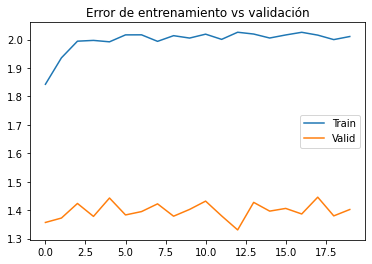

In [86]:
plt.plot(history["train_loss"])
plt.plot(history["valid_loss"])
plt.title("Error de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()